# QR Decomposition

## Theoretical Foundation

QR decomposition (also called QR factorization) is a fundamental matrix factorization technique in numerical linear algebra. Given an $m \times n$ matrix $A$ with $m \geq n$, the QR decomposition expresses $A$ as the product of two matrices:

$$A = QR$$

where:
- $Q$ is an $m \times m$ orthogonal matrix (i.e., $Q^T Q = QQ^T = I$)
- $R$ is an $m \times n$ upper triangular matrix

### Properties of Orthogonal Matrices

An orthogonal matrix $Q$ satisfies:
- $Q^{-1} = Q^T$
- $\|Qx\|_2 = \|x\|_2$ for any vector $x$ (norm preservation)
- $\det(Q) = \pm 1$

### The Gram-Schmidt Process

One classical method to compute QR decomposition is the **Gram-Schmidt orthogonalization** process. Given the columns of $A$ as $\{a_1, a_2, \ldots, a_n\}$, we construct orthonormal vectors $\{q_1, q_2, \ldots, q_n\}$ as follows:

For $k = 1, 2, \ldots, n$:

$$u_k = a_k - \sum_{j=1}^{k-1} \text{proj}_{q_j}(a_k)$$

where the projection is:

$$\text{proj}_{q_j}(a_k) = \frac{\langle a_k, q_j \rangle}{\langle q_j, q_j \rangle} q_j = \langle a_k, q_j \rangle q_j$$

Then normalize:

$$q_k = \frac{u_k}{\|u_k\|_2}$$

The elements of $R$ are computed as:

$$r_{jk} = \langle a_k, q_j \rangle \quad \text{for } j \leq k$$

### Applications

QR decomposition is used extensively in:
1. **Solving least squares problems**: For overdetermined systems $Ax = b$
2. **Eigenvalue algorithms**: The QR algorithm for computing eigenvalues
3. **Computing orthonormal bases**: For subspaces spanned by column vectors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Set random seed for reproducibility
np.random.seed(42)

## Implementation: Classical Gram-Schmidt

We first implement the classical Gram-Schmidt algorithm to understand the underlying mechanics.

In [2]:
def classical_gram_schmidt(A):
    """
    Compute QR decomposition using Classical Gram-Schmidt.
    
    Parameters:
    -----------
    A : ndarray
        Input matrix of shape (m, n) with m >= n
    
    Returns:
    --------
    Q : ndarray
        Orthogonal matrix of shape (m, n)
    R : ndarray
        Upper triangular matrix of shape (n, n)
    """
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    
    for k in range(n):
        # Start with the k-th column of A
        u = A[:, k].copy()
        
        # Subtract projections onto previous q vectors
        for j in range(k):
            R[j, k] = np.dot(Q[:, j], A[:, k])
            u = u - R[j, k] * Q[:, j]
        
        # Normalize
        R[k, k] = np.linalg.norm(u)
        if R[k, k] > 1e-10:
            Q[:, k] = u / R[k, k]
        else:
            Q[:, k] = u
    
    return Q, R

## Implementation: Modified Gram-Schmidt

The Modified Gram-Schmidt (MGS) algorithm improves numerical stability by updating the vector $u_k$ immediately after each projection is subtracted, rather than computing all projections from the original $a_k$.

In [3]:
def modified_gram_schmidt(A):
    """
    Compute QR decomposition using Modified Gram-Schmidt.
    
    This version has better numerical stability than Classical GS.
    
    Parameters:
    -----------
    A : ndarray
        Input matrix of shape (m, n) with m >= n
    
    Returns:
    --------
    Q : ndarray
        Orthogonal matrix of shape (m, n)
    R : ndarray
        Upper triangular matrix of shape (n, n)
    """
    m, n = A.shape
    Q = A.astype(float).copy()
    R = np.zeros((n, n))
    
    for k in range(n):
        # Compute the norm of the current column
        R[k, k] = np.linalg.norm(Q[:, k])
        
        if R[k, k] > 1e-10:
            Q[:, k] = Q[:, k] / R[k, k]
        
        # Orthogonalize remaining columns against q_k
        for j in range(k + 1, n):
            R[k, j] = np.dot(Q[:, k], Q[:, j])
            Q[:, j] = Q[:, j] - R[k, j] * Q[:, k]
    
    return Q, R

## Demonstration: Basic QR Decomposition

Let's create a test matrix and compute its QR decomposition using our implementations and compare with NumPy's built-in function.

In [4]:
# Create a test matrix
A = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 7],
    [10, 11, 12]
], dtype=float)

print("Original Matrix A:")
print(A)
print(f"\nShape: {A.shape}")

Original Matrix A:
[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  7.]
 [10. 11. 12.]]

Shape: (4, 3)


In [5]:
# Compute QR using different methods
Q_cgs, R_cgs = classical_gram_schmidt(A)
Q_mgs, R_mgs = modified_gram_schmidt(A)
Q_np, R_np = np.linalg.qr(A)

print("Classical Gram-Schmidt Q:")
print(Q_cgs)
print("\nClassical Gram-Schmidt R:")
print(R_cgs)

Classical Gram-Schmidt Q:
[[ 0.07761505  0.83305216  0.11952286]
 [ 0.31046021  0.45123659  0.23904572]
 [ 0.54330537  0.06942101 -0.83666003]
 [ 0.77615053 -0.31239456  0.47809144]]

Classical Gram-Schmidt R:
[[12.88409873 14.59162988 15.2125503 ]
 [ 0.          1.0413152   1.94378838]
 [ 0.          0.          1.67332005]]


In [6]:
# Verify the decomposition: A = QR
print("Verification: ||A - QR|| (should be ~0)")
print(f"Classical GS: {np.linalg.norm(A - Q_cgs @ R_cgs):.2e}")
print(f"Modified GS:  {np.linalg.norm(A - Q_mgs @ R_mgs):.2e}")
print(f"NumPy QR:     {np.linalg.norm(A - Q_np @ R_np):.2e}")

Verification: ||A - QR|| (should be ~0)
Classical GS: 9.93e-16
Modified GS:  0.00e+00
NumPy QR:     1.85e-14


In [7]:
# Verify orthogonality: Q^T Q should be identity
print("\nOrthogonality check: ||Q^T Q - I|| (should be ~0)")
n = A.shape[1]
print(f"Classical GS: {np.linalg.norm(Q_cgs.T @ Q_cgs - np.eye(n)):.2e}")
print(f"Modified GS:  {np.linalg.norm(Q_mgs.T @ Q_mgs - np.eye(n)):.2e}")
print(f"NumPy QR:     {np.linalg.norm(Q_np.T @ Q_np - np.eye(n)):.2e}")


Orthogonality check: ||Q^T Q - I|| (should be ~0)
Classical GS: 1.49e-14
Modified GS:  1.83e-15
NumPy QR:     1.11e-15


## Numerical Stability Analysis

A key difference between Classical and Modified Gram-Schmidt appears when dealing with ill-conditioned matrices. Let's investigate this with a Hilbert matrix, which is notoriously ill-conditioned.

In [8]:
def hilbert_matrix(n):
    """Generate an n x n Hilbert matrix."""
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            H[i, j] = 1.0 / (i + j + 1)
    return H

# Test with different sizes of Hilbert matrices
sizes = [5, 8, 10, 12]
cgs_errors = []
mgs_errors = []
np_errors = []
condition_numbers = []

for n in sizes:
    H = hilbert_matrix(n)
    cond = np.linalg.cond(H)
    condition_numbers.append(cond)
    
    # Compute QR decompositions
    Q_cgs, R_cgs = classical_gram_schmidt(H)
    Q_mgs, R_mgs = modified_gram_schmidt(H)
    Q_np, R_np = np.linalg.qr(H)
    
    # Measure loss of orthogonality
    cgs_errors.append(np.linalg.norm(Q_cgs.T @ Q_cgs - np.eye(n)))
    mgs_errors.append(np.linalg.norm(Q_mgs.T @ Q_mgs - np.eye(n)))
    np_errors.append(np.linalg.norm(Q_np.T @ Q_np - np.eye(n)))
    
    print(f"n={n}: cond(H)={cond:.2e}, CGS={cgs_errors[-1]:.2e}, MGS={mgs_errors[-1]:.2e}, NumPy={np_errors[-1]:.2e}")

n=5: cond(H)=4.77e+05, CGS=7.78e-08, MGS=1.71e-11, NumPy=8.64e-16
n=8: cond(H)=1.53e+10, CGS=1.42e+00, MGS=3.62e-07, NumPy=1.11e-15
n=10: cond(H)=1.60e+13, CGS=3.47e+00, MGS=1.00e+00, NumPy=1.50e-15
n=12: cond(H)=1.75e+16, CGS=5.48e+00, MGS=1.41e+00, NumPy=1.52e-15


## Application: Solving Least Squares Problems

QR decomposition provides a numerically stable method for solving least squares problems. Given an overdetermined system $Ax = b$, we seek $x$ that minimizes $\|Ax - b\|_2$.

Using $A = QR$, the solution is:

$$x = R^{-1} Q^T b$$

Since $R$ is upper triangular, this can be solved efficiently via back-substitution.

In [9]:
# Generate synthetic data for least squares fitting
m = 100  # Number of data points
n = 4    # Polynomial degree + 1

# True coefficients
true_coeffs = np.array([2.0, -1.5, 0.5, 0.1])

# Generate noisy data
x_data = np.linspace(0, 3, m)
noise = 0.5 * np.random.randn(m)

# y = c0 + c1*x + c2*x^2 + c3*x^3 + noise
y_data = np.polyval(true_coeffs[::-1], x_data) + noise

# Build Vandermonde matrix
A_ls = np.vander(x_data, n, increasing=True)

print(f"Design matrix A shape: {A_ls.shape}")
print(f"True coefficients: {true_coeffs}")

Design matrix A shape: (100, 4)
True coefficients: [ 2.  -1.5  0.5  0.1]


In [10]:
def solve_least_squares_qr(A, b):
    """
    Solve least squares problem Ax = b using QR decomposition.
    """
    Q, R = modified_gram_schmidt(A)
    
    # Compute Q^T b
    Qtb = Q.T @ b
    
    # Back-substitution to solve Rx = Q^T b
    n = R.shape[1]
    x = np.zeros(n)
    
    for i in range(n - 1, -1, -1):
        x[i] = (Qtb[i] - np.dot(R[i, i+1:], x[i+1:])) / R[i, i]
    
    return x

# Solve using our QR method
coeffs_qr = solve_least_squares_qr(A_ls, y_data)

# Compare with NumPy's lstsq
coeffs_np, _, _, _ = np.linalg.lstsq(A_ls, y_data, rcond=None)

print(f"True coefficients:   {true_coeffs}")
print(f"QR solution:         {coeffs_qr}")
print(f"NumPy lstsq:         {coeffs_np}")
print(f"\nDifference QR vs NumPy: {np.linalg.norm(coeffs_qr - coeffs_np):.2e}")

True coefficients:   [ 2.  -1.5  0.5  0.1]
QR solution:         [ 2.22149009 -2.61448965  1.39107922 -0.08896793]
NumPy lstsq:         [ 2.22149009 -2.61448965  1.39107922 -0.08896793]

Difference QR vs NumPy: 1.29e-14


## Visualization

Let's create a comprehensive visualization showing:
1. The numerical stability comparison between CGS and MGS
2. The least squares polynomial fit
3. The structure of Q and R matrices

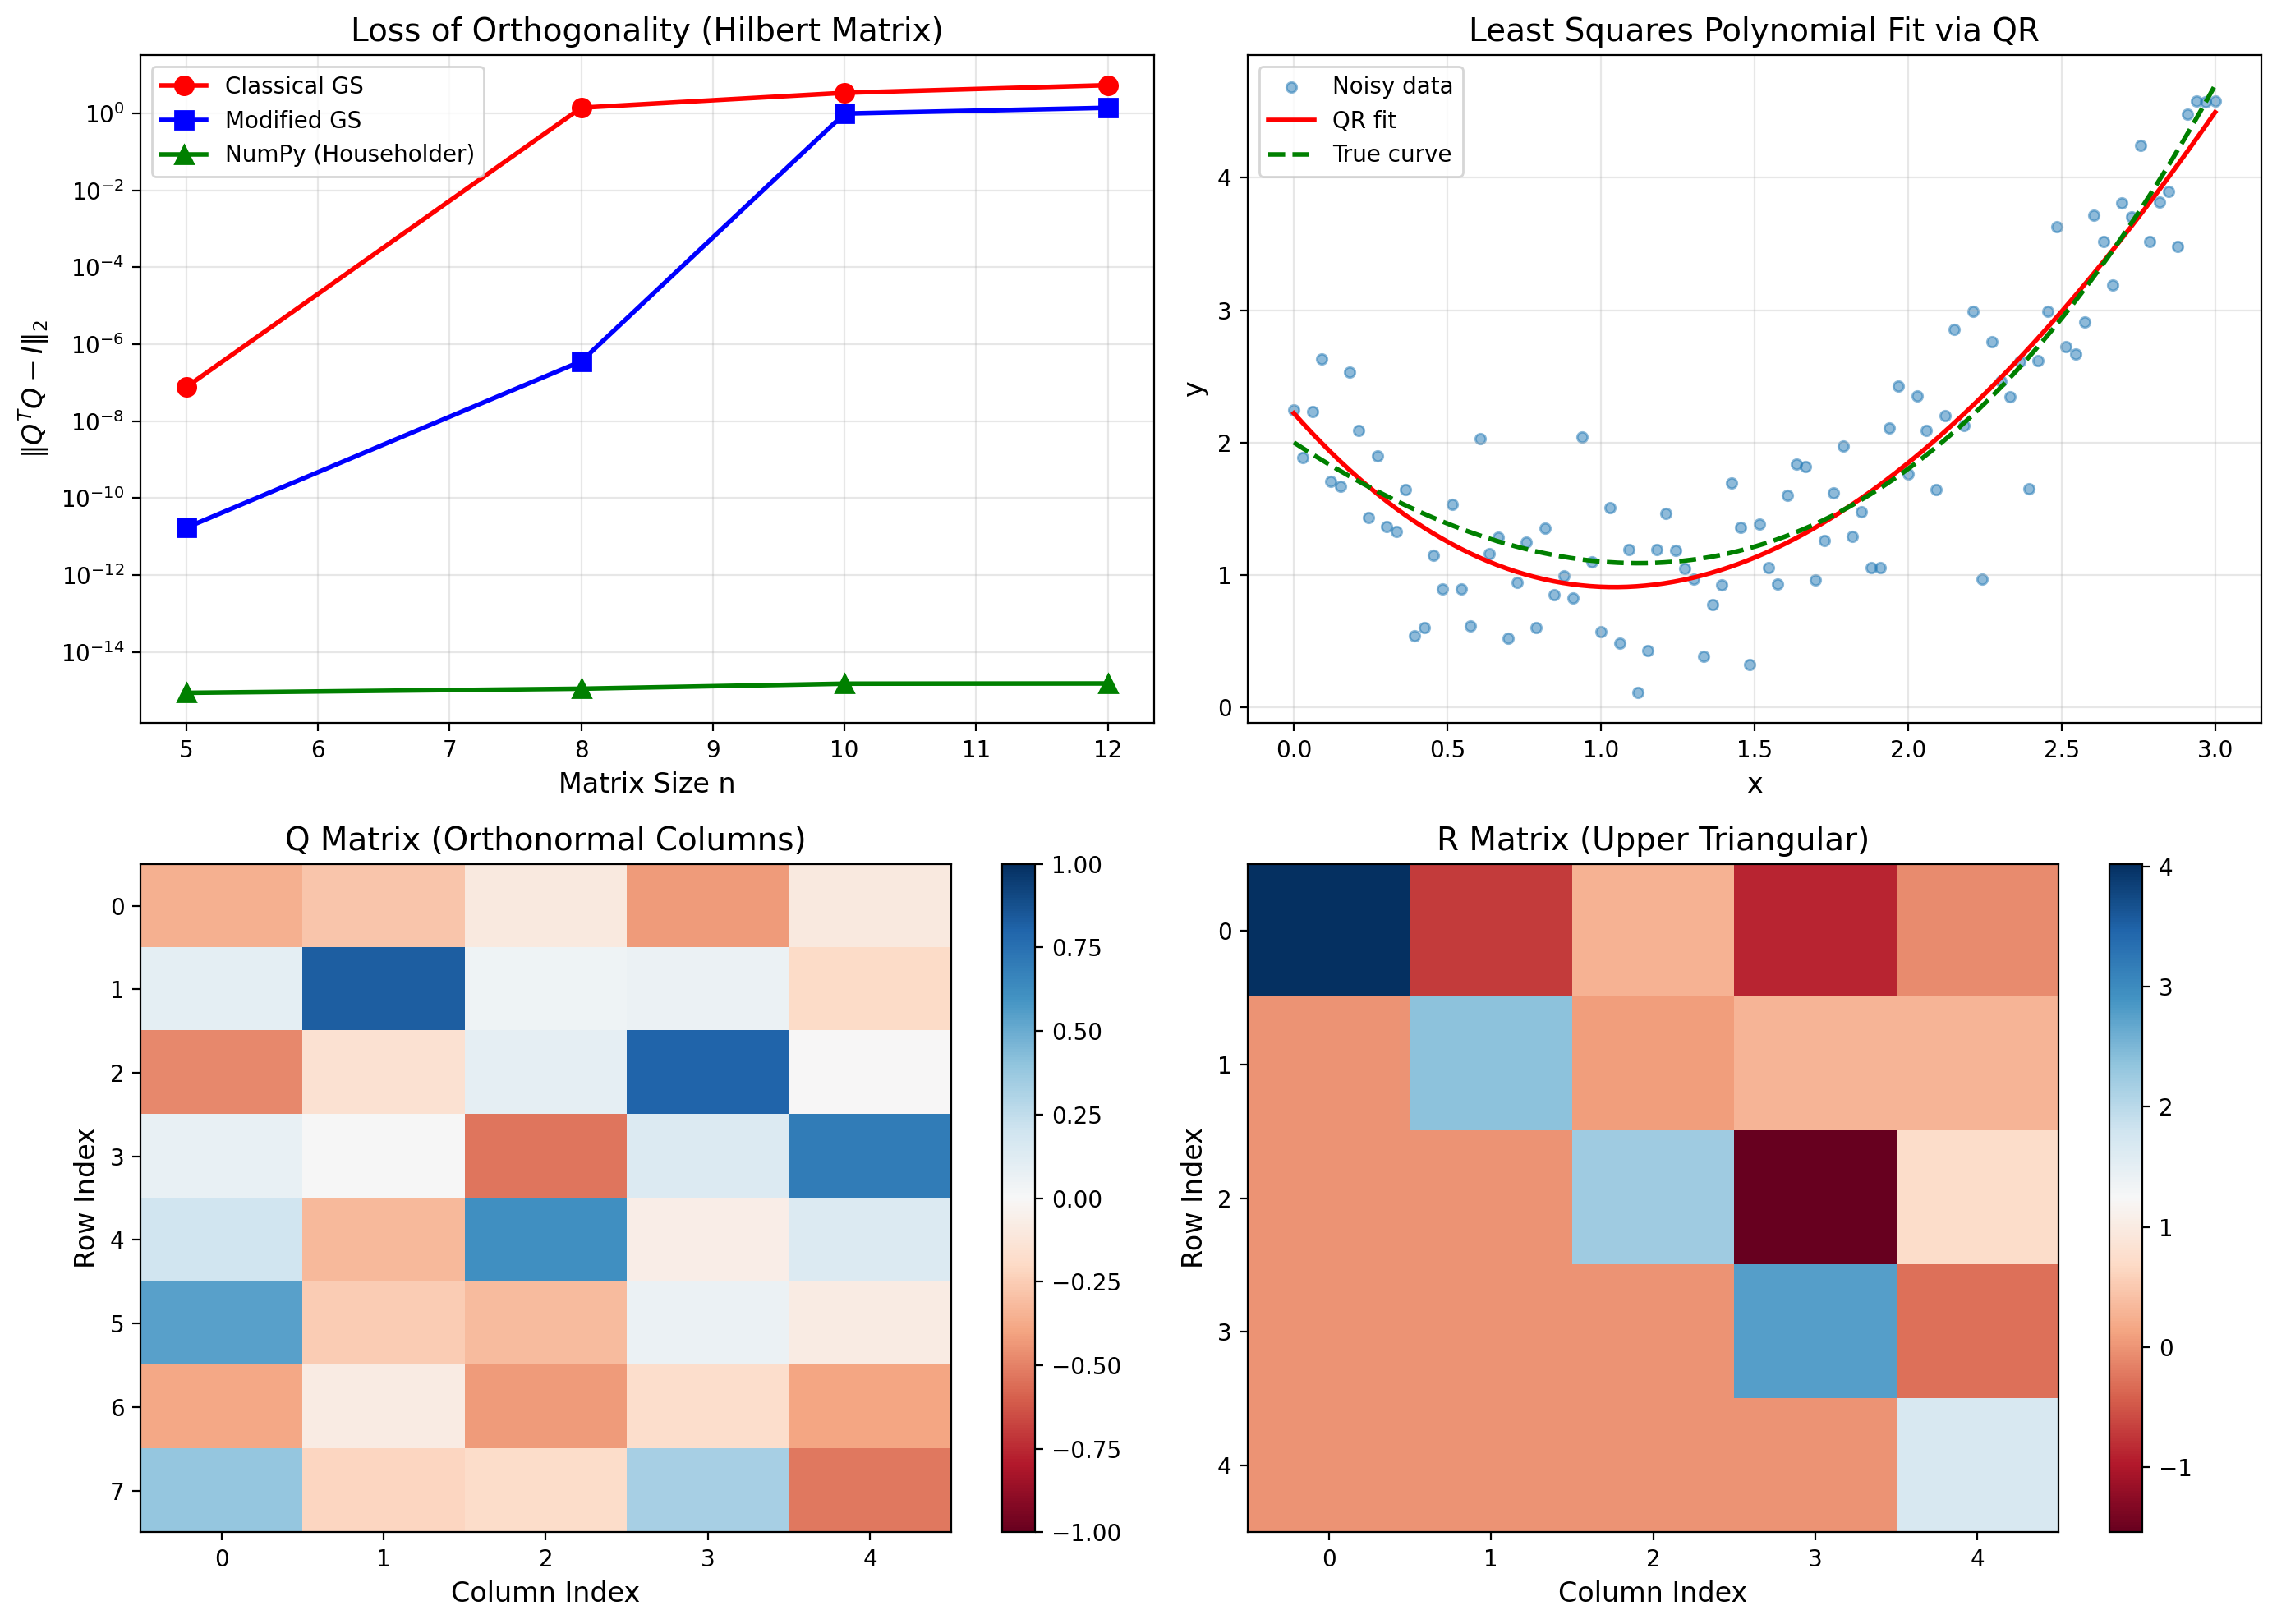


Figure saved to 'plot.png'


In [11]:
fig = plt.figure(figsize=(14, 10))

# Plot 1: Numerical stability comparison
ax1 = fig.add_subplot(2, 2, 1)
ax1.semilogy(sizes, cgs_errors, 'ro-', label='Classical GS', linewidth=2, markersize=8)
ax1.semilogy(sizes, mgs_errors, 'bs-', label='Modified GS', linewidth=2, markersize=8)
ax1.semilogy(sizes, np_errors, 'g^-', label='NumPy (Householder)', linewidth=2, markersize=8)
ax1.set_xlabel('Matrix Size n', fontsize=12)
ax1.set_ylabel(r'$\|Q^T Q - I\|_2$', fontsize=12)
ax1.set_title('Loss of Orthogonality (Hilbert Matrix)', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Least squares fit
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(x_data, y_data, alpha=0.5, s=20, label='Noisy data')
x_smooth = np.linspace(0, 3, 200)
y_fit = np.polyval(coeffs_qr[::-1], x_smooth)
y_true = np.polyval(true_coeffs[::-1], x_smooth)
ax2.plot(x_smooth, y_fit, 'r-', linewidth=2, label='QR fit')
ax2.plot(x_smooth, y_true, 'g--', linewidth=2, label='True curve')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title('Least Squares Polynomial Fit via QR', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Structure of Q matrix
ax3 = fig.add_subplot(2, 2, 3)
A_demo = np.random.randn(8, 5)
Q_demo, R_demo = modified_gram_schmidt(A_demo)
im3 = ax3.imshow(Q_demo, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
ax3.set_xlabel('Column Index', fontsize=12)
ax3.set_ylabel('Row Index', fontsize=12)
ax3.set_title('Q Matrix (Orthonormal Columns)', fontsize=14)
plt.colorbar(im3, ax=ax3)

# Plot 4: Structure of R matrix
ax4 = fig.add_subplot(2, 2, 4)
im4 = ax4.imshow(R_demo, cmap='RdBu', aspect='auto')
ax4.set_xlabel('Column Index', fontsize=12)
ax4.set_ylabel('Row Index', fontsize=12)
ax4.set_title('R Matrix (Upper Triangular)', fontsize=14)
plt.colorbar(im4, ax=ax4)

plt.tight_layout()
plt.savefig('qr_decomposition_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Summary

In this notebook, we explored QR decomposition:

1. **Theory**: QR factorization expresses a matrix as $A = QR$ where $Q$ is orthogonal and $R$ is upper triangular.

2. **Algorithms**: We implemented both Classical and Modified Gram-Schmidt, demonstrating that MGS has superior numerical stability.

3. **Numerical Stability**: Using Hilbert matrices, we showed that CGS suffers from loss of orthogonality for ill-conditioned matrices, while MGS maintains better stability.

4. **Applications**: We demonstrated solving least squares problems using QR decomposition, achieving results comparable to optimized library functions.

### Key Takeaways

- Modified Gram-Schmidt is preferred over Classical Gram-Schmidt for numerical stability
- For production code, use library implementations (e.g., `numpy.linalg.qr`) which typically use Householder reflections
- QR decomposition is the preferred method for solving least squares problems due to its numerical stability